In [11]:
!pip install scikit-allel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.1 MB/s eta 0:00:0000:0100:01m


In [12]:
import allel
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import gaussian_kde

In [ ]:
vcf_path = r"../data/genotypes.vcf"
callset = allel.read_vcf(vcf_path)

/opt/conda/lib/python3.10/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


In [24]:
# Создаем фигуру с несколькими подграфиками
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 12))

/tmp/ipykernel_30/1739253348.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1500x1200 with 0 Axes>

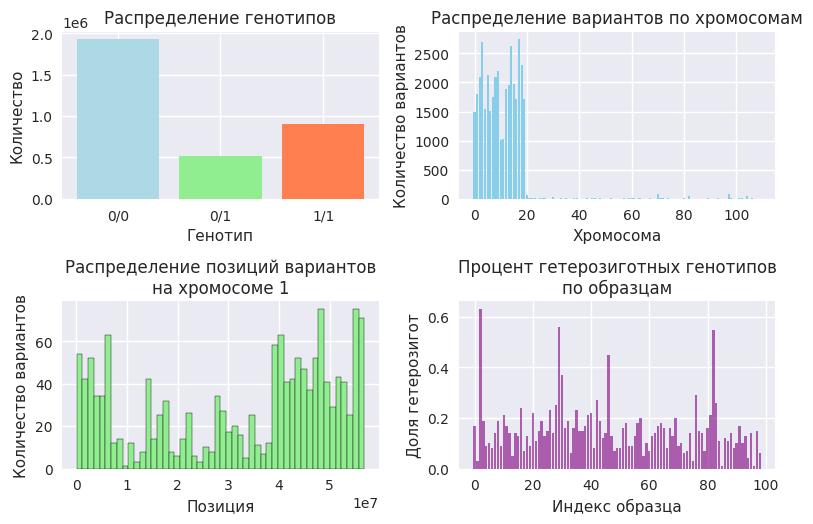

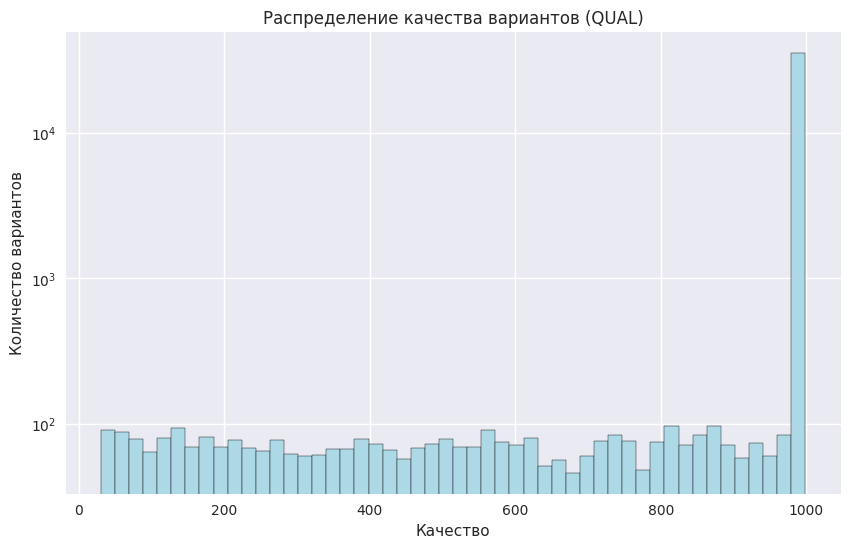


Статистика по образцам:
Всего вариантов: 38940
Всего образцов: 99

Топ-5 образцов с наибольшей гетерозиготностью:
Образец PS000028: 33.42% гетерозигот
Образец PS000115: 33.20% гетерозигот
Образец PS000078: 32.42% гетерозигот
Образец PS000210: 27.28% гетерозигот
Образец PS000079: 25.73% гетерозигот


In [36]:
# 1. Распределение генотипов
gt = callset['calldata/GT']
genotype_counts = np.zeros((3,))  # для 0/0, 0/1, 1/1

for sample_gts in gt.reshape(-1, 2):  # Преобразуем в 2D массив генотипов
    if np.array_equal(sample_gts, [0, 0]):
        genotype_counts[0] += 1
    elif np.array_equal(sample_gts, [0, 1]) or np.array_equal(sample_gts, [1, 0]):
        genotype_counts[1] += 1
    elif np.array_equal(sample_gts, [1, 1]):
        genotype_counts[2] += 1

plt.subplot(2, 2, 1)
plt.bar(['0/0', '0/1', '1/1'], genotype_counts, color=['lightblue', 'lightgreen', 'coral'])
plt.title('Распределение генотипов')
plt.ylabel('Количество')
plt.xlabel('Генотип')

# 2. Распределение вариантов по хромосомам
plt.subplot(2, 2, 2)
chrom = callset['variants/CHROM']
chrom_counts = dict(zip(*np.unique(chrom, return_counts=True)))
sorted_chroms = sorted(chrom_counts.keys(), 
                      key=lambda x: (len(x), int(x.replace('KZ848124', '999')) if x.isdigit() else 999))
counts = [chrom_counts[c] for c in sorted_chroms]
plt.bar(range(len(sorted_chroms)), counts, color='skyblue')
# Убрали эту строку: plt.xticks(range(len(sorted_chroms)), sorted_chroms, rotation=45)
plt.title('Распределение вариантов по хромосомам')
plt.xlabel('Хромосома')
plt.ylabel('Количество вариантов')

# 3. Распределение позиций вариантов на выбранной хромосоме
plt.subplot(2, 2, 3)
chrom_1_mask = chrom == '1'
pos_chrom_1 = callset['variants/POS'][chrom_1_mask]
plt.hist(pos_chrom_1, bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение позиций вариантов\nна хромосоме 1')
plt.xlabel('Позиция')
plt.ylabel('Количество вариантов')

# 4. Карта генотипов по образцам
plt.subplot(2, 2, 4)
sample_heterozygosity = []
n_samples = gt.shape[1]
n_variants = min(100, gt.shape[0])  # Берем первые 100 вариантов для наглядности

# Вычисляем процент гетерозиготных генотипов для каждого образца
for i in range(n_samples):
    sample_gts = gt[:n_variants, i]
    het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    sample_heterozygosity.append(het_count / n_variants)

plt.bar(range(n_samples), sample_heterozygosity, color='purple', alpha=0.6)
plt.title('Процент гетерозиготных генотипов\nпо образцам')
plt.xlabel('Индекс образца')
plt.ylabel('Доля гетерозигот')

plt.tight_layout()
plt.show()

# 5. Дополнительный график: распределение качества вариантов
plt.figure(figsize=(10, 6))
qual = callset['variants/QUAL']
plt.hist(qual, bins=50, color='lightblue', edgecolor='black')
plt.title('Распределение качества вариантов (QUAL)')
plt.xlabel('Качество')
plt.ylabel('Количество вариантов')
plt.yscale('log')  # Используем логарифмическую шкалу для лучшей визуализации
plt.show()

# 6. Статистика по образцам
total_variants = gt.shape[0]
n_samples = gt.shape[1]
sample_names = callset['samples']

print("\nСтатистика по образцам:")
print(f"Всего вариантов: {total_variants}")
print(f"Всего образцов: {n_samples}")

# Вычисляем статистику по генотипам для каждого образца
het_stats = []
for i, sample in enumerate(sample_names):
    sample_gts = gt[:, i]
    het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    hom_ref_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 0]))
    hom_alt_count = sum(1 for gt in sample_gts if np.array_equal(gt, [1, 1]))
    het_stats.append({
        'sample': sample,
        'het_ratio': het_count / total_variants,
        'hom_ref_ratio': hom_ref_count / total_variants,
        'hom_alt_ratio': hom_alt_count / total_variants
    })

# Выводим топ-5 образцов с наибольшей гетерозиготностью
print("\nТоп-5 образцов с наибольшей гетерозиготностью:")
sorted_stats = sorted(het_stats, key=lambda x: x['het_ratio'], reverse=True)
for stat in sorted_stats[:5]:
    print(f"Образец {stat['sample']}: {stat['het_ratio']:.2%} гетерозигот")

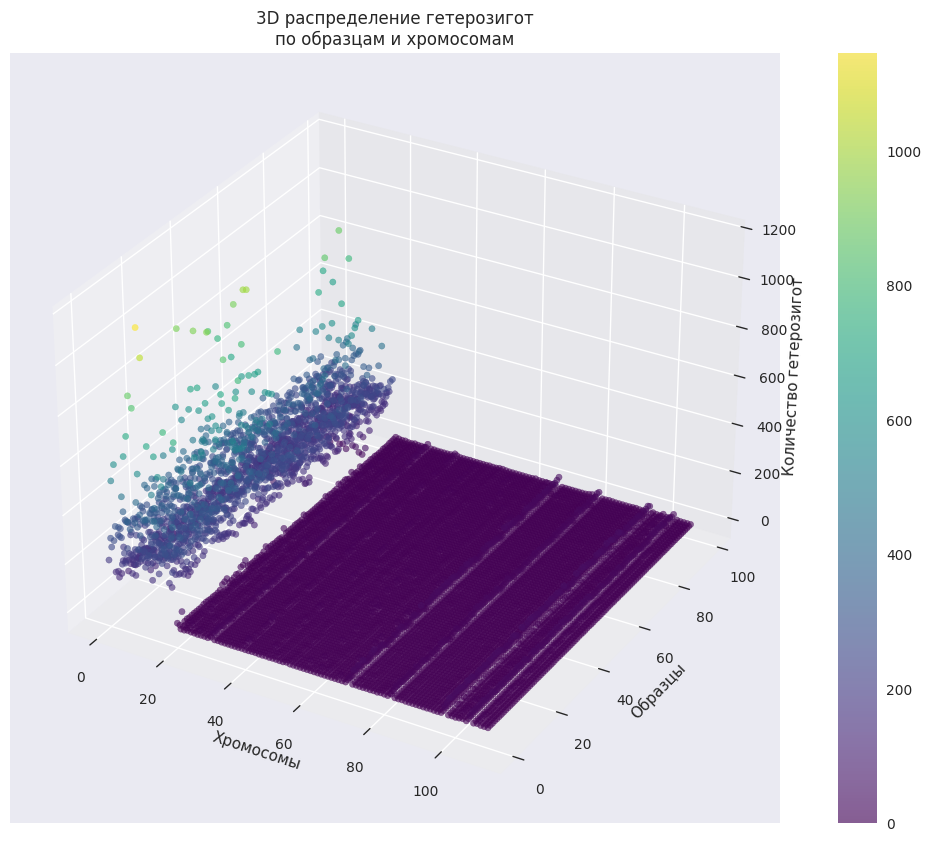

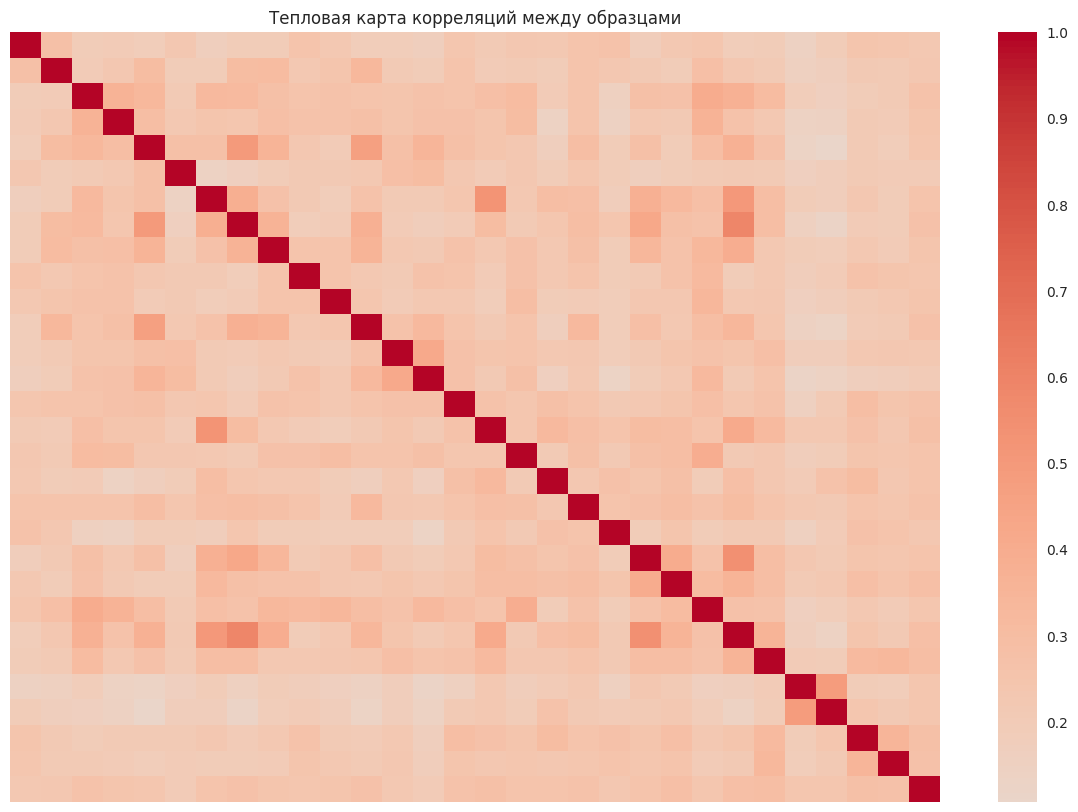

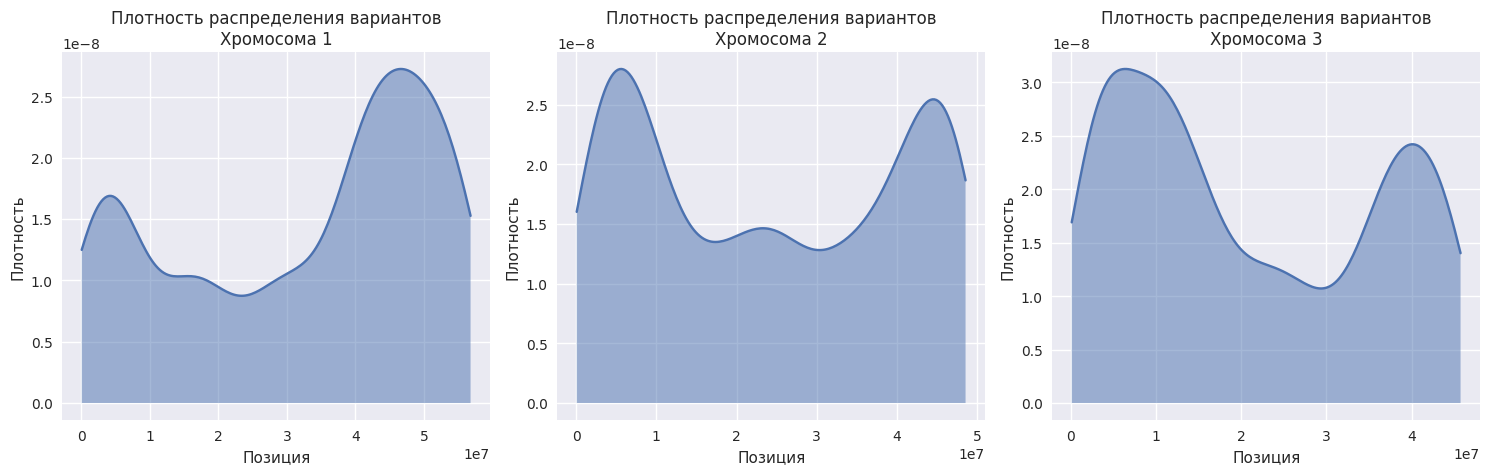

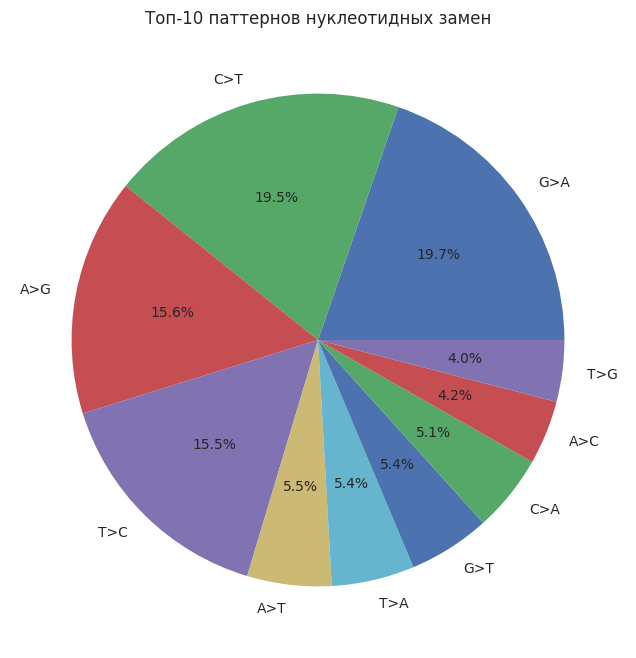

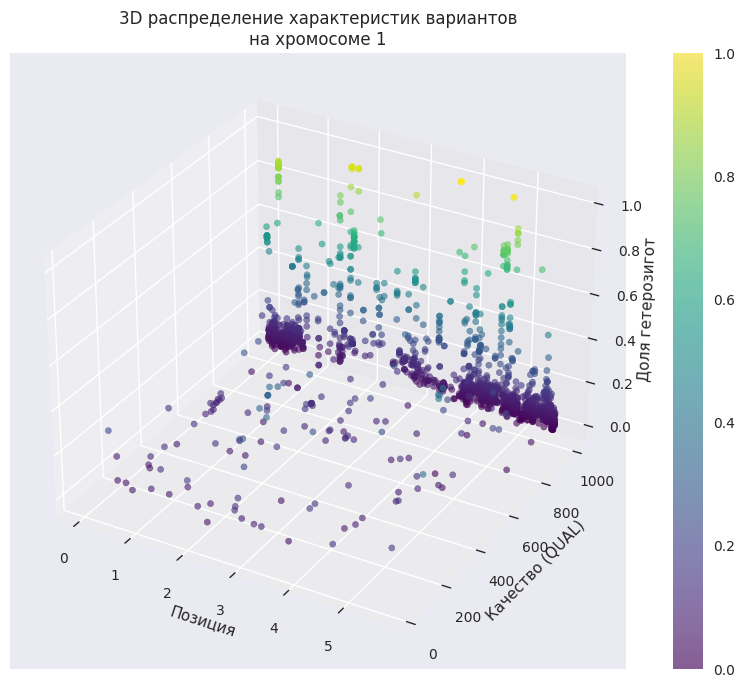


Статистика по нуклеотидным заменам:
G>A: 6515 случаев (18.4%)
C>T: 6461 случаев (18.2%)
A>G: 5145 случаев (14.5%)
T>C: 5137 случаев (14.5%)
A>T: 1829 случаев (5.2%)
T>A: 1797 случаев (5.1%)
G>T: 1773 случаев (5.0%)
C>A: 1677 случаев (4.7%)
A>C: 1386 случаев (3.9%)
T>G: 1336 случаев (3.8%)

Статистика по гетерозиготности:
Средняя доля гетерозигот: 0.175
Медианная доля гетерозигот: 0.101
Максимальная доля гетерозигот: 1.000


In [37]:
# 1. 3D график распределения генотипов по образцам и хромосомам
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Подготавливаем данные
gt = callset['calldata/GT']
chroms = callset['variants/CHROM']
n_samples = gt.shape[1]
n_variants = gt.shape[0]

# Создаем массивы для координат
x_coords = []  # хромосомы
y_coords = []  # образцы
z_coords = []  # количество гетерозигот

unique_chroms = np.unique(chroms)
chrom_to_idx = {chrom: idx for idx, chrom in enumerate(unique_chroms)}

for i in range(n_samples):
    for chrom in unique_chroms:
        mask = chroms == chrom
        sample_gts = gt[mask, i]
        het_count = sum(1 for gt in sample_gts if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
        x_coords.append(chrom_to_idx[chrom])
        y_coords.append(i)
        z_coords.append(het_count)

scatter = ax.scatter(x_coords, y_coords, z_coords, c=z_coords, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
ax.set_xlabel('Хромосомы')
ax.set_ylabel('Образцы')
ax.set_zlabel('Количество гетерозигот')
ax.set_title('3D распределение гетерозигот\nпо образцам и хромосомам')
plt.show()

# 2. Тепловая карта корреляций между образцами
plt.figure(figsize=(15, 10))

# Создаем матрицу корреляций между образцами
n_samples_for_corr = min(30, n_samples)  # Ограничиваем количество образцов для наглядности
correlation_matrix = np.zeros((n_samples_for_corr, n_samples_for_corr))

for i in range(n_samples_for_corr):
    for j in range(n_samples_for_corr):
        # Считаем корреляцию между генотипами образцов
        gts_i = np.sum(gt[:, i], axis=1)
        gts_j = np.sum(gt[:, j], axis=1)
        correlation = np.corrcoef(gts_i, gts_j)[0, 1]
        correlation_matrix[i, j] = correlation

sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            xticklabels=False, yticklabels=False)
plt.title('Тепловая карта корреляций между образцами')
plt.show()

# 3. Плотность распределения вариантов по позициям для первых трех хромосом
plt.figure(figsize=(15, 5))

for idx, chrom in enumerate(['1', '2', '3']):
    plt.subplot(1, 3, idx + 1)
    mask = chroms == chrom
    positions = callset['variants/POS'][mask]
    
    if len(positions) > 0:
        # Оценка плотности распределения
        kernel = gaussian_kde(positions)
        x_range = np.linspace(min(positions), max(positions), 200)
        density = kernel(x_range)
        
        plt.plot(x_range, density)
        plt.fill_between(x_range, density, alpha=0.5)
        plt.title(f'Плотность распределения вариантов\nХромосома {chrom}')
        plt.xlabel('Позиция')
        plt.ylabel('Плотность')

plt.tight_layout()
plt.show()

# 4. Круговая диаграмма соотношения REF/ALT для топ-10 паттернов замен
plt.figure(figsize=(12, 8))

ref = callset['variants/REF']
alt = callset['variants/ALT'][:, 0]  # Берем первый альтернативный аллель
substitutions = {}

for r, a in zip(ref, alt):
    if len(r) == 1 and len(a) == 1 and a != '':  # Только однонуклеотидные замены
        key = f'{r}>{a}'
        substitutions[key] = substitutions.get(key, 0) + 1

# Берем топ-10 паттернов замен
top_substitutions = dict(sorted(substitutions.items(), key=lambda x: x[1], reverse=True)[:10])

plt.pie(top_substitutions.values(), labels=top_substitutions.keys(), autopct='%1.1f%%')
plt.title('Топ-10 паттернов нуклеотидных замен')
plt.show()

# 5. 3D scatter plot качества, позиции и гетерозиготности
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Выберем данные для первой хромосомы для наглядности
chrom_mask = chroms == '1'
positions = callset['variants/POS'][chrom_mask]
qual = callset['variants/QUAL'][chrom_mask]

# Подсчитаем гетерозиготность для каждого варианта
het_rates = []
for variant_gt in gt[chrom_mask]:
    het_count = sum(1 for gt in variant_gt if np.array_equal(gt, [0, 1]) or np.array_equal(gt, [1, 0]))
    het_rates.append(het_count / n_samples)

scatter = ax.scatter(positions, qual, het_rates, 
                    c=het_rates, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
ax.set_xlabel('Позиция')
ax.set_ylabel('Качество (QUAL)')
ax.set_zlabel('Доля гетерозигот')
ax.set_title('3D распределение характеристик вариантов\nна хромосоме 1')
plt.show()

# Выведем некоторую статистику
print("\nСтатистика по нуклеотидным заменам:")
for pattern, count in top_substitutions.items():
    print(f"{pattern}: {count} случаев ({count/sum(substitutions.values())*100:.1f}%)")

print("\nСтатистика по гетерозиготности:")
print(f"Средняя доля гетерозигот: {np.mean(het_rates):.3f}")
print(f"Медианная доля гетерозигот: {np.median(het_rates):.3f}")
print(f"Максимальная доля гетерозигот: {np.max(het_rates):.3f}")